In [1]:
%load_ext autoreload
%autoreload 2

In [76]:
import os
if "notebooks" in os.getcwd():
    os.chdir("..")

import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype

import warnings
warnings.filterwarnings("ignore")
from src.preprocessing.parser import parse_data
from src.mapping import get_movie_id_name_map

from scipy.sparse import csr_matrix, coo_matrix

In [3]:
features = pd.read_parquet("data/parsed/parsed_1.parquet")

In [36]:
movie_titles= pd.read_csv(
    "data/movie_titles.csv", 
    encoding="latin-1",
    on_bad_lines='skip',
    names=["movie_id", "year", "name"]
)

In [37]:
movie_titles

,movie_id,year,name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17429,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17430,17767,2004.0,Fidel Castro: American Experience
17431,17768,2000.0,Epoch
17432,17769,2003.0,The Company


In [46]:
id_name_dict = movie_titles.set_index("movie_id")\
    .name\
    .to_dict()

In [58]:
features['movie_id'] = features.movie_id\
    .apply(lambda x: int(x))

In [62]:
best_rated_movies = features\
    .groupby("movie_id")\
    .mean()\
    .sort_values(by= 'rating')

In [66]:
names = best_rated_movies\
    .index\
    .map(id_name_dict)

best_rated_movies.index = names

In [83]:
best_rated_movies.tail()

,rating
movie_id,
Lord of the Rings: The Return of the King: Extended Edition: Bonus Material,4.552000
Inu-Yasha,4.554434
The Simpsons: Season 6,4.581296
Ghost in the Shell: Stand Alone Complex: 2nd Gig,4.586364
Lost: Season 1,4.670989


<BarContainer object of 5 artists>

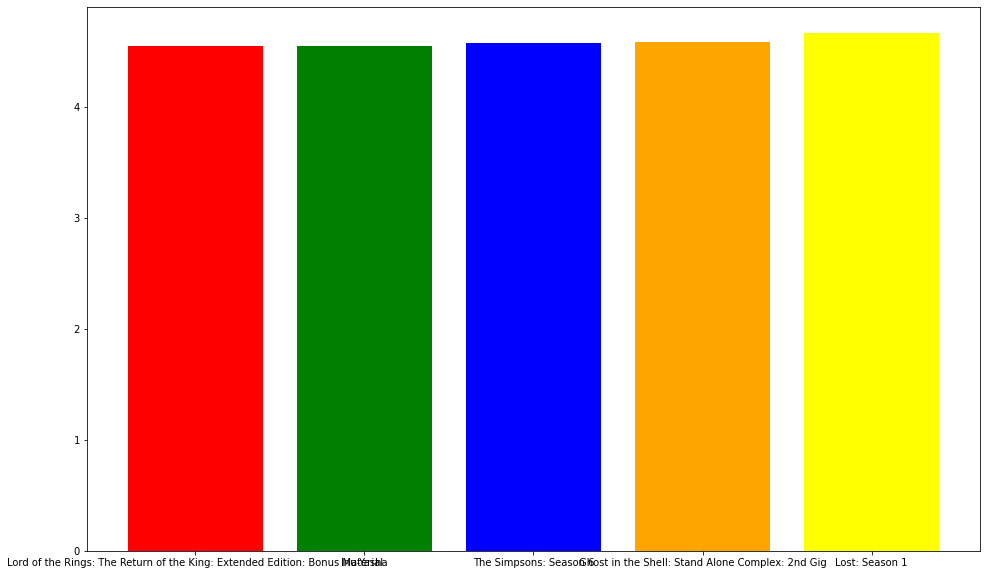

In [82]:
plt.figure(figsize=(16,10))
plt.bar(
    best_rated_movies.tail().index, 
    best_rated_movies.tail().rating,
    color = ['red', 'green', 'blue', 'orange', 'yellow']    
)

## Creating sparse matrix

In [6]:
movies = features['movie_id'].unique()
users = features['user_id'].unique()

In [8]:
user_cat = CategoricalDtype(categories=sorted(users), ordered=True)
movie_cat = CategoricalDtype(categories=sorted(movies), ordered=True)
user_index = features["user_id"]\
    .astype(user_cat)\
    .cat\
    .codes
movie_index = features["movie_id"]\
    .astype(movie_cat)\
    .cat\
    .codes

In [12]:
coo = coo_matrix(
    (features["rating"], (user_index, movie_index)), 
    shape=(len(users), len(movies)),
    
)
sparse_features = coo.tocsr()

In [18]:
reviews_matrix = pd.DataFrame.sparse.from_spmatrix(sparse_features)\
   

In [19]:
reviews_matrix.replace(0, np.nan)

TypeError: SparseArray does not support item assignment via setitem